# **Maestría en Inteligencia Artificial Aplicada**

## **Curso:** Análisis de grandes volúmenes de datos

## **Tecnológico de Monterrey**

## **Actividad 5:**  Visualización de resultados
## **Equipo :** 13
## **Integrantes :** 
- Kevin Balderas Sánchez – A01795149
- Alan Jasso Arenas – A01383272
- José Florencio Maguey Peralta – A01796727
- Oscar Luis Guadarrama Jiménez – A01796245


## Inicio y Preparación del Entorno

En esta sección se realiza la configuración inicial para la ejecución del experimento. Se importan las librerías necesarias, se crea la sesión de Spark y se carga el dataset `muestra_M_indexado.csv`, generado previamente en la Actividad 4. Este dataset corresponde a una muestra representativa de la población original, ya depurada, caracterizada e indexada.

Finalmente, se realiza una revisión preliminar de su estructura para asegurar que se encuentra en condiciones óptimas para el proceso de validación cruzada.


In [24]:
# -------------------------
# SESIÓN SPARK Y CONFIGURACIÓN
# -------------------------
from pyspark.sql import SparkSession

# -------------------------
# TRANSFORMACIONES EN SPARK
# -------------------------
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, when, isnan, count, round, regexp_replace, expr, lit,
    percentile_approx, first, sum, skewness, log1p
)
from pyspark.sql.types import IntegerType

# -------------------------
# PREPROCESAMIENTO
# -------------------------
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

# -------------------------
# MODELOS SUPERVISADOS
# -------------------------
from pyspark.ml.classification import RandomForestClassifier

# -------------------------
# EVALUACIÓN DE MODELOS
# -------------------------
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator
)

# -------------------------
# ANÁLISIS Y VISUALIZACIÓN
# -------------------------
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# LIBRERÍAS ADICIONALES DE SKLEARN
# -------------------------
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


In [3]:
spark = SparkSession.builder \
    .appName("Entrenamiento Optimizado") \
    .master("local[*]") \
    .config("spark.driver.memory", "48g") \
    .config("spark.executor.memory", "48g") \
    .config("spark.sql.shuffle.partitions", "64") \
    .config("spark.default.parallelism", "64") \
    .getOrCreate()

In [4]:
spark 

In [5]:
# Leer el CSV
muestra_M = spark.read.csv("muestra_M.csv", header=True, inferSchema=True)

# Verifica la carga
muestra_M.show(5)


+---------+--------+-----------------+-----+----------+--------------+------------------+-------------------+-----------+------------+------------------+------------------+------------------+-----------------+----------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+-------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+----------------+------------------+------------------+--------------------------+
|loan_amnt|int_rate|      installment|grade|emp_length|home_ownership|        annual_inc|verification_status|loan_status|     purpose|               dti|    inq_last_6mths|          open_acc|        revol_bal|revol_util|         total_acc|        out_prncp|      total_pymnt|   total_rec

In [6]:
muestra_M.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_rev_hi_lim: double (nullable = true)
 |-- acc_op

In [7]:
reg = muestra_M.count()

print("numero total de registros:", reg)

numero total de registros: 337413


In [8]:
# Ver cuántos valores nulos hay por columna 
print("Valores nulos por columna:")
muestra_M.select([count(when(col(c).isNull(), c)).alias(c) for c in muestra_M.columns]).show(truncate=False)

Valores nulos por columna:
+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+-------+---+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+--------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_

## 1. Proceso de Validación Cruzada

Para evaluar la estabilidad y capacidad de generalización del modelo de clasificación entrenado, se implementó una estrategia de validación cruzada utilizando el enfoque k-fold estratificado. Este método divide la muestra representativa M en k subconjuntos del mismo tamaño, manteniendo la proporción de clases en la variable objetivo (loan_status).

En este proyecto se seleccionó un valor de k = 5, ya que la muestra contiene aproximadamente 337,413 registros, con una distribución de clases claramente desbalanceada, aunque aún suficientemente representativa:

|loan_status|	cantidad|
|-----------|-----------|
|0          |	293,438 |
|1	        |   43,975  |


Esto representa aproximadamente un 87% de clase 0 y un 13% de clase 1, por lo que se justifica el uso de una validación cruzada estratificada, que permita conservar esta proporción en cada fold.

La elección de k=5 permite:

- Garantizar que cada fold contenga suficientes datos para representar el comportamiento de ambas clases.

- Reducir la varianza de las métricas frente a una validación simple (train/test split).

- Minimizar el riesgo de sobreajuste al evaluar el modelo en múltiples subconjuntos independientes.

- Mantener el costo computacional dentro de márgenes razonables, dado el volumen de datos.

Durante esta validación cruzada, se utilizará el modelo que reportó mejor desempeño en la Actividad 4 (Random Forest Classifier), conservando las variables de caracterización utilizadas para construir la muestra M.


In [9]:
# Ver la distribución de la variable objetivo
muestra_M.groupBy('loan_status').count().orderBy("count", ascending=False).show()


+-----------+------+
|loan_status| count|
+-----------+------+
|          0|293438|
|          1| 43975|
+-----------+------+



## 2. Construcción de los k-folds

Para construir los pliegues requeridos en la validación cruzada, se utilizó la técnica de StratifiedKFold de la biblioteca scikit-learn. Este método garantiza que cada fold conserve una proporción similar de clases en la variable objetivo loan_status, lo cual es esencial considerando el desbalance observado entre las clases.

Se dividió el dataset en 5 folds, asignando a cada registro una etiqueta numérica del 0 al 4 en una nueva columna llamada fold. Esta columna permite controlar qué subconjunto se usará como conjunto de validación en cada iteración del entrenamiento, asegurando que todos los datos sean utilizados tanto para entrenamiento como para prueba a lo largo del proceso.

La distribución final se verificó con un conteo cruzado entre fold y loan_status, confirmando la uniformidad del muestreo estratificado.


In [10]:
df_pd = muestra_M.toPandas()

In [11]:
# Número de folds
k = 5

# Inicializar la columna
df_pd["fold"] = -1

# Inicializar el objeto StratifiedKFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

# Asignar folds
for fold, (_, val_idx) in enumerate(skf.split(X=df_pd, y=df_pd["loan_status"])):
    df_pd.loc[val_idx, "fold"] = fold
    
df_pd.to_csv('muestra_M_fold.csv', index=False)

In [12]:
print(df_pd.groupby(["fold", "loan_status"]).size())

fold  loan_status
0     0              58688
      1               8795
1     0              58688
      1               8795
2     0              58688
      1               8795
3     0              58687
      1               8795
4     0              58687
      1               8795
dtype: int64


In [13]:
df_folds =  spark.read.csv("muestra_M_fold.csv", header=True, inferSchema=True)

## 3. Experimentación

En esta etapa se realizó el proceso de entrenamiento del modelo **Random Forest Classifier**, considerado el mejor modelo evaluado en la Actividad 4.

El entrenamiento se repitió cinco veces, usando la estrategia de validación cruzada `k-fold` con `k=5`, donde en cada iteración se utilizaron cuatro folds como conjunto de entrenamiento y el restante como conjunto de prueba.

Como métrica principal de evaluación se utilizó el **AUC (Área bajo la Curva ROC)**, ya que permite medir la capacidad del modelo para distinguir entre clases, especialmente útil en datasets desbalanceados.

Los resultados obtenidos en cada fold fueron almacenados para su posterior análisis visual y discusión.


In [14]:
# 1. Detectar columnas categóricas
columnas_categoricas = [c for c, dtype in df_folds.dtypes if dtype == 'string' and c not in ['fold', 'loan_status']]

# 2. Indexar y codificar
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in columnas_categoricas]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in columnas_categoricas]

# 3. Crear lista de columnas finales para ensamblar (numéricas + codificadas)
columnas_numericas = [c for c in df_folds.columns if c not in columnas_categoricas + ['fold', 'loan_status']]
columnas_finales = columnas_numericas + [col + "_vec" for col in columnas_categoricas]
target = "loan_status"

# 4. Ensamblar features
assembler = VectorAssembler(inputCols=columnas_finales, outputCol="features")

# 5. Construir Pipeline de preprocesamiento
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# 6. Ejecutar pipeline
df_folds_as = pipeline.fit(df_folds).transform(df_folds)

In [15]:
# Evaluadores
evaluator_auc = BinaryClassificationEvaluator(labelCol=target, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="weightedRecall")

In [16]:
resultados_folds = []
matrices_confusion = []

for i in range(5):
    print(f"\nEntrenando Fold {i}")
    try:
        train_df = df_folds_as.filter(col("fold") != i)
        test_df = df_folds_as.filter(col("fold") == i)

        rf = RandomForestClassifier(
            labelCol=target,
            featuresCol="features",
            numTrees=100,
            maxDepth=10,
            seed=1
        )

        modelo = rf.fit(train_df)
        pred_train = modelo.transform(train_df)
        predicciones = modelo.transform(test_df)

        # Calcular métricas
        auc = evaluator_auc.evaluate(predicciones)
        acc = evaluator_acc.evaluate(predicciones)
        f1 = evaluator_f1.evaluate(predicciones)
        precision = evaluator_precision.evaluate(predicciones)
        recall = evaluator_recall.evaluate(predicciones)
        acc_train = evaluator_acc.evaluate(pred_train)
        f1_train = evaluator_f1.evaluate(pred_train)

        resultados_folds.append({
            "fold": i,
            "AUC": auc,
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
            "Train_Accuracy": acc_train,
            "Train_F1": f1_train
        })

        # Matriz de confusión
        matriz = predicciones.groupBy(target, "prediction").count().orderBy(target, "prediction")
        matrices_confusion.append(matriz)

        print(f"Fold {i} AUC: {auc:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}| Accuracy_train: {acc_train:.4f} | F1_train: {f1_train:.4f} | ")
    except Exception as e:
        print(f"Error en Fold {i}: {e}")




Entrenando Fold 0
Fold 0 AUC: 0.9660 | Accuracy: 0.9556 | F1: 0.9516 | Precision: 0.9577 | Recall: 0.9556| Accuracy_train: 0.9564 | F1_train: 0.9525 | 

Entrenando Fold 1
Fold 1 AUC: 0.9649 | Accuracy: 0.9551 | F1: 0.9511 | Precision: 0.9572 | Recall: 0.9551| Accuracy_train: 0.9565 | F1_train: 0.9527 | 

Entrenando Fold 2
Fold 2 AUC: 0.9658 | Accuracy: 0.9594 | F1: 0.9561 | Precision: 0.9611 | Recall: 0.9594| Accuracy_train: 0.9605 | F1_train: 0.9575 | 

Entrenando Fold 3
Fold 3 AUC: 0.9657 | Accuracy: 0.9567 | F1: 0.9529 | Precision: 0.9587 | Recall: 0.9567| Accuracy_train: 0.9576 | F1_train: 0.9540 | 

Entrenando Fold 4
Fold 4 AUC: 0.9627 | Accuracy: 0.9580 | F1: 0.9544 | Precision: 0.9598 | Recall: 0.9580| Accuracy_train: 0.9610 | F1_train: 0.9580 | 


## 4. Visualización de Resultados

En esta sección se presentan las visualizaciones generadas a partir de los resultados obtenidos durante la experimentación con validación cruzada. Las métricas evaluadas en cada fold permiten observar la estabilidad del modelo, así como identificar posibles variaciones en su rendimiento.

A continuación, se muestran las gráficas más relevantes:

- **Boxplot de métricas (Accuracy, F1, Precision, Recall)**.
- **Grafica de barras (Accuracy, F1, Precision, Recall)** por fold.
- **Curva ROC promedio** del modelo, tomando los valores de predicción en cada iteración.
- **Matriz de confusión consolidada**, sumando los errores de clasificación acumulados.

Estas visualizaciones permiten identificar si el modelo presenta inestabilidad, sobreajuste o sesgo hacia alguna de las clases, complementando el análisis numérico realizado anteriormente.


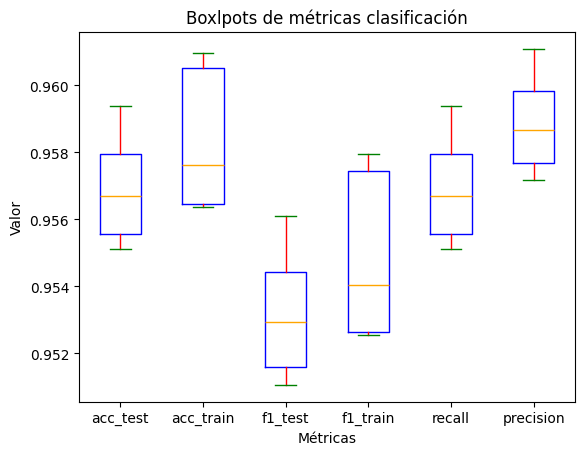

In [26]:
acc_test = [fold['Accuracy'] for fold in resultados_folds]
acc_train = [fold['Train_Accuracy'] for fold in resultados_folds]

f1_test = [fold['F1'] for fold in resultados_folds]
f1_train = [fold['Train_F1'] for fold in resultados_folds]

recall_test = [fold['Recall'] for fold in resultados_folds]
precision_test = [fold['Precision'] for fold in resultados_folds]

dict_met = {"acc_test":acc_test, "acc_train":acc_train, "f1_test":f1_test, "f1_train":f1_train, "recall":recall_test, "precision":precision_test}
plt.boxplot(dict_met.values(), boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'), tick_labels=dict_met.keys())
plt.title('Boxlpots de métricas clasificación')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.show()

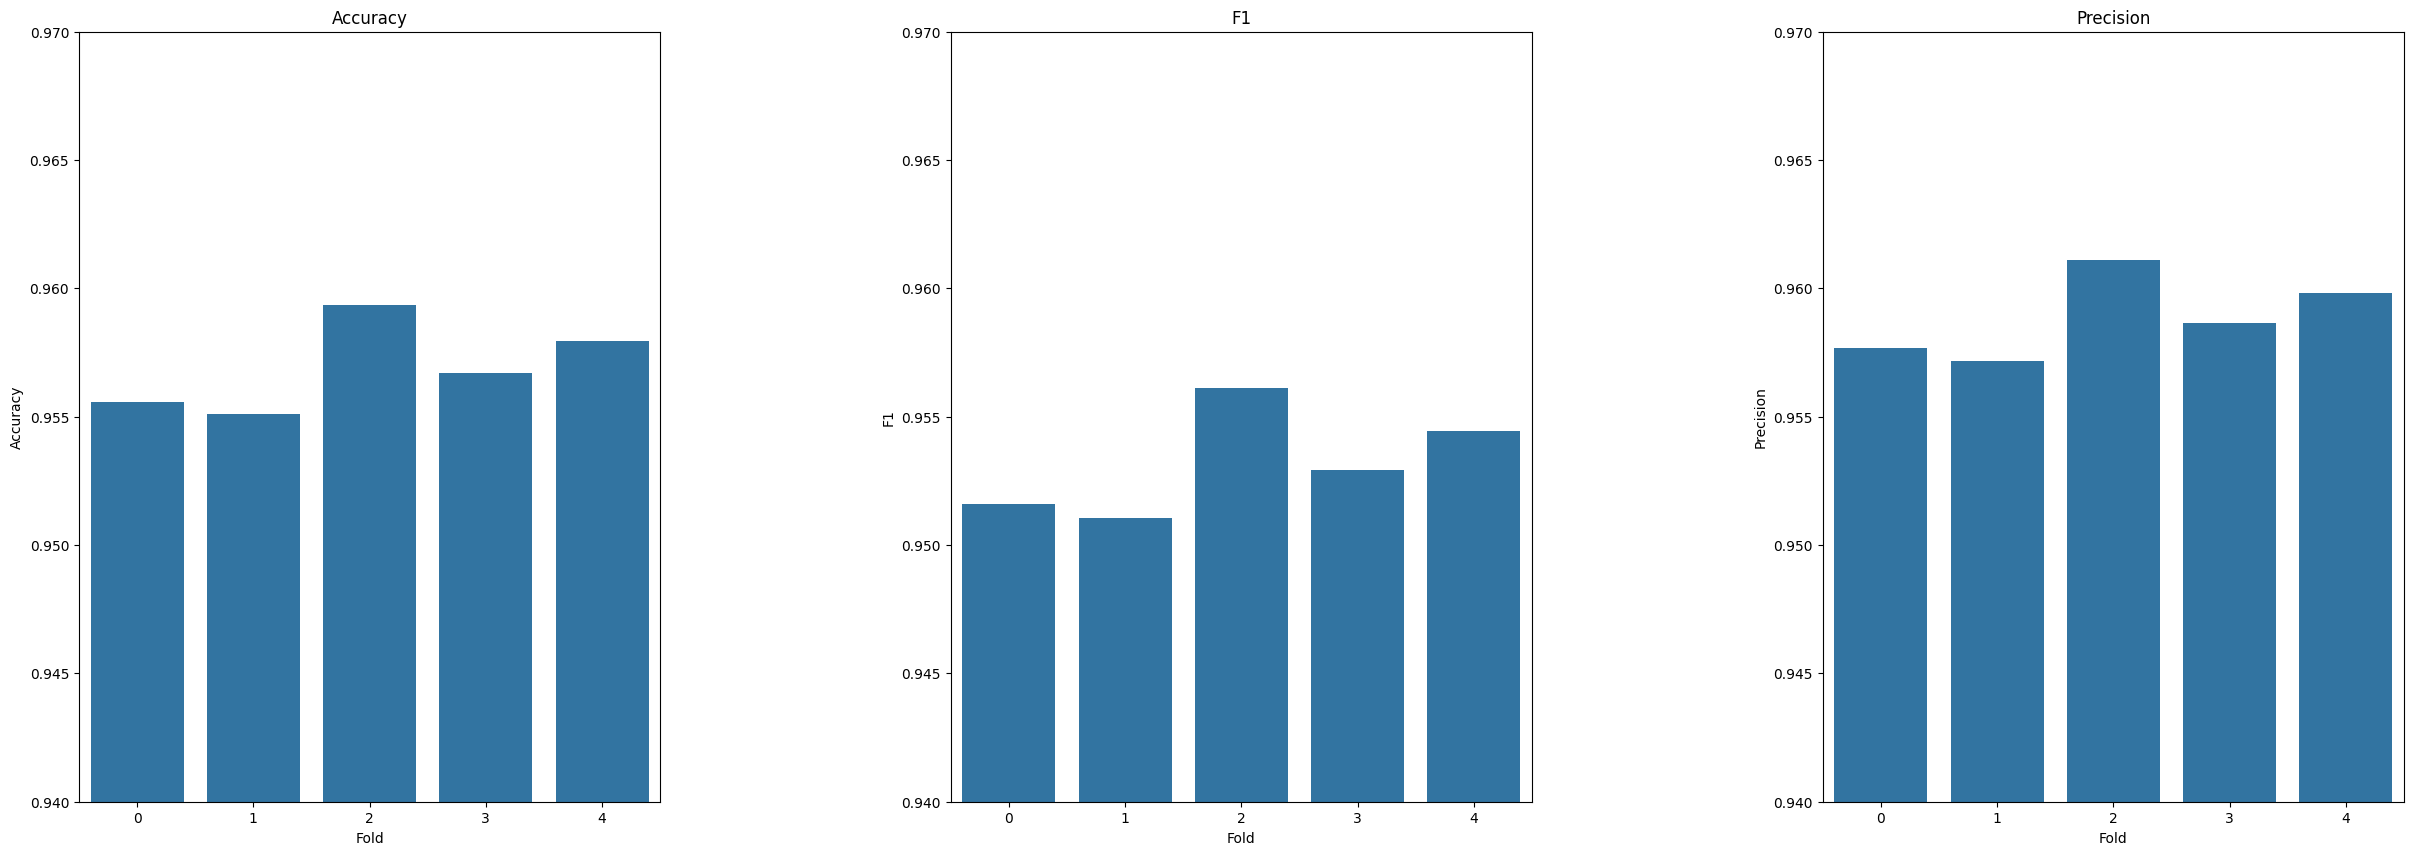

In [18]:
df_metrics= pd.DataFrame(resultados_folds)
df_metrics


fig, axes = plt.subplots(1,3, figsize=(30, 10))
plt.subplots_adjust(wspace=0.5)
axes = axes.ravel()
# Lista de las métricas que quieres graficar
metrics = ['Accuracy', 'F1', 'Precision']

for metric, ax in zip(metrics, axes):
    sns.barplot(
        data=df_metrics,
        x='fold',
        y=metric,
        ax=ax,
    )
    ax.set(title=metric, xlabel='Fold', ylabel=metric)
    ax.set_ylim(0.94,0.97)

plt.show()

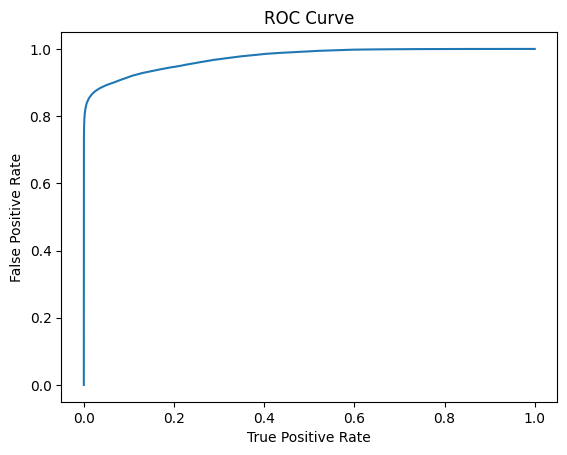

Training set areaUnderROC: 0.9737426519973656


In [27]:
trainingSummary = modelo.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

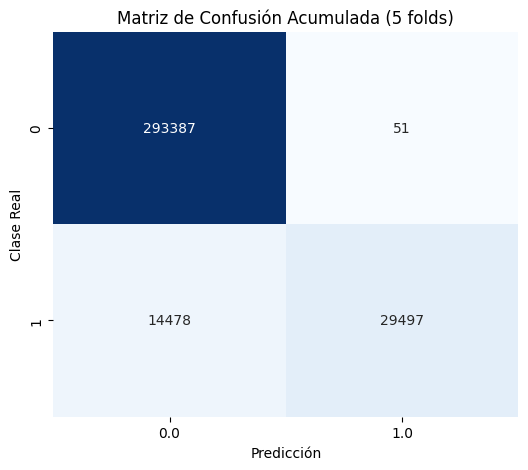

In [20]:
matriz_total = None
for matriz in matrices_confusion:
    df = matriz.toPandas().pivot(index="loan_status", columns="prediction", values="count").fillna(0)
    if matriz_total is None:
        matriz_total = df
    else:
        matriz_total += df

plt.figure(figsize=(6, 5))
sns.heatmap(matriz_total, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión Acumulada (5 folds)")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.show()
